In [1]:
import sys
# sys.path.append(r"Y:\Users\Yingyue\Gates_Lab_Suite-master")
sys.path.append(r"/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/")
sys.path.append(r"/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/")
from Core_Definition import *
from Auto_Algorithm import *
from Visualization import *
import os
from SPAM import *
import numpy as np
import xlsxwriter as xlsx
from scipy import optimize
import random
import math
from math import floor
import pickle
import uuid

In [3]:
import json, pickle
import qiskit
#transpiler reducinig qiskit circuit to QASM strings
from qiskit import transpile
# Use AerSimulator
from qiskit_aer import AerSimulator
from qiskit import IBMQ, QuantumCircuit, execute
# from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.extensions import UnitaryGate
from qiskit.quantum_info import Pauli, Clifford, Statevector,Operator
from qiskit.visualization import array_to_latex
from scipy.stats import sem, unitary_group
from scipy.linalg import sqrtm,expm
import qiskit.quantum_info as qi
from qiskit.quantum_info import Pauli
import pylatexenc

/var/folders/6l/f5pw0tyx785dhvmqpb7282h00000gn/T/ipykernel_32232/1375469573.py:9: DeprecationWarning: The qiskit.extensions module is deprecated since Qiskit 0.46.0. It will be removed in the Qiskit 1.0 release.
  from qiskit.extensions import UnitaryGate


In [4]:
from scipy.optimize import curve_fit
from copy import copy, deepcopy
def rcs_fit_fun_depth1(x, alpha):
        #return a * np.exp(-alpha * x)
        return alpha ** x

def fit_EAB_depth1(X, xeb_list):
    Y = [np.mean(xeb_list[L]) for L in X]
    Yerr = [sem(xeb_list[L]) for L in X]
    #print(linregress(X,np.log(Y)))
    
    
    try:
        params, pcov = curve_fit(rcs_fit_fun_depth1, X, Y, sigma=Yerr, absolute_sigma=True, p0=[1])
        alpha = params[0]
        params_err = np.sqrt(np.diag(pcov))
        alpha_err = params_err[0]

    except RuntimeError:
        alpha = 1.0
        alpha_err = 0.0


    return alpha, alpha_err

    print(alpha, alpha_err)

def int_to_pauli(i,n):
    p = np.base_repr(i,base=4)
    p = '0'*(n-len(p)) + p
    p = p.replace('0','I').replace('1', 'X').replace('2', 'Y').replace('3', 'Z')
    return p

def commute(p,q):
    c = 1
    n = len(p)
    for i in range(n):
        if p[i] != 'I' and q[i] != 'I':
            if p[i] != q[i]:
                c *= -1
    return c

def fidelity_to_error(pauli_fidelity,n):
    N = 4**n
    pauli_error = {}
    for i in range(N):
        p = int_to_pauli(i,n)
        pauli_error[p] = 0
        for j in range(N):
            q = int_to_pauli(j,n)
            pauli_error[p] += pauli_fidelity[q] * commute(p,q) / N
    return pauli_error
    

In [5]:
import random   
def rcs_fit_fun(x, a, alpha):
        #return a * np.exp(-alpha * x)
        return a * (alpha ** x)

def fit_EAB_plot(X, xeb_list):
    Y = [np.mean(xeb_list[L]) for L in X]
    Yerr = [sem(xeb_list[L]) for L in X]
    #print(linregress(X,np.log(Y)))
    
    
    try:
        params, pcov = curve_fit(rcs_fit_fun, X, Y, sigma=Yerr, absolute_sigma=True, p0=[1,1])
        alpha = params[1]
        a=params[0]
        params_err = np.sqrt(np.diag(pcov))
        alpha_err = params_err[1]

    except RuntimeError:
        alpha = 1.0
        alpha_err = 0.0

    # params, pcov = curve_fit(rcs_fit_fun, X, Y, sigma=Yerr, absolute_sigma=True, p0=[1,1])
    # #params, pcov = curve_fit(rcs_fit_fun, X, Y, absolute_sigma=True, p0=[1,1])


    # print(params)

    return alpha,a, alpha_err,Y, Yerr

    print(alpha, alpha_err)



In [6]:
# filename = str(uuid.uuid4())
# filename+="XX23541_noSE_explicitCNOT_XX_R_0711_01+10_ExperimentalData"
with open("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/FTXX EAB 01162024/results/535a56ad-ac6e-41c8-93dc-dc5e7383eac8FTXX_EAB_23541_01162024_01+10_ExperimentalData", "rb") as fp:
    eab_load_cpy=pickle.load(fp)
print (eab_load_cpy)

[{'n': 2, 'L': 2, 'clifford': {'stabilizer': ['+IZ', '+ZI'], 'destabilizer': ['+IX', '+XI']}, 'clifford_layer': 'XX', 'counts': {'0000': 4, '1000': 39, '0100': 34, '1100': 1625, '0010': 2, '1010': 1, '0110': 34, '1110': 101, '0001': 4, '1001': 36, '0101': 5, '1101': 103, '0011': 0, '1011': 2, '0111': 3, '1111': 7}}, {'n': 2, 'L': 2, 'clifford': {'stabilizer': ['-IZ', '-ZI'], 'destabilizer': ['+IX', '-XI']}, 'clifford_layer': 'XX', 'counts': {'0000': 179, '1000': 22, '0100': 0, '1100': 10, '0010': 1659, '1010': 32, '0110': 12, '1110': 3, '0001': 5, '1001': 0, '0101': 3, '1101': 3, '0011': 51, '1011': 3, '0111': 13, '1111': 5}}, {'n': 2, 'L': 2, 'clifford': {'stabilizer': ['-IZ', '-ZI'], 'destabilizer': ['+IX', '-XI']}, 'clifford_layer': 'XX', 'counts': {'0000': 247, '1000': 17, '0100': 5, '1100': 3, '0010': 1518, '1010': 33, '0110': 22, '1110': 44, '0001': 19, '1001': 3, '0101': 6, '1101': 0, '0011': 60, '1011': 1, '0111': 14, '1111': 8}}, {'n': 2, 'L': 2, 'clifford': {'stabilizer': ['-

In [7]:
sys.path.append(r"/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation")
import EAB_process_modified 
import itertools
import pdb

'''Specify a set of Pauli you want to estimate'''
# C=10
C=20
nqubit=2
depth=[2,4,8,16,32]
shots=2000
pauli_request_list = [''.join(s) for s in itertools.product(['I','X','Y','Z'], repeat = nqubit)] #full

#process_EAB(Lrange, cb_data, pauli_request_list)
eab_result=EAB_process_modified.process_EAB_01(depth, eab_load_cpy, pauli_request_list)
# eab_result_spam=EAB_process_modified.process_EAB(depth, eab_load_cpy, pauli_request_list)

print (eab_result)


{'fidelity_list': {'II': {2: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 4: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 8: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 16: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 32: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}, 'IX': {2: [0.84, 0.917, 0.889, 0.887, 0.8, 0.906, 0.793, 0.85, 0.847, 0.862, 0.841, 0.837, 0.894, 0.826, 0.919, 0.785, 0.879, 0.911, 0.928, 0.885], 4: [0.799, 0.744, 0.812, 0.725, 0.813, 0.731, 0.846, 0.848, 0.882, 0.712, 0.853, 0.791, 0.691, 0.733, 0.903, 0.839, 0.798, 0.781, 0.836, 0.859], 8: [0.817, 0.783, 0.854, 0.894, 0.833, 0.828, 0.761, 0.848, 0.852, 0.795, 0.877, 0.796, 0.76, 0.834, 0.711, 0.831, 0.812, 0.795, 0.752, 0.878], 16: [0.69

Data analysis: no bootstrapping, different depth

Analyze full set of data without bootstrapping

Parameters: n = 2, C = 20,  L =  [2, 4, 8, 16, 32]
Measurement based simulation, shots = 2000
No readout error
Total error =  0.023598693661342374
Label / Pauli infidelity / Standard deviation
II 0.0 0.0
XI 0.0151574 0.0009081
YI 0.0236976 0.0013867
ZI 0.0207446 0.001017
IX 0.0220553 0.0012216
XX 0.0339476 0.001582
YX 0.0302465 0.001486
ZX 0.0287909 0.0014524
IY 0.0275689 0.001431
XY 0.0286213 0.0014814
YY 0.0392689 0.0015672
ZY 0.029806 0.0013174
IZ 0.020327 0.0010272
XZ 0.023278 0.0013346
YZ 0.0228583 0.0011905
ZZ 0.0112107 0.0005533


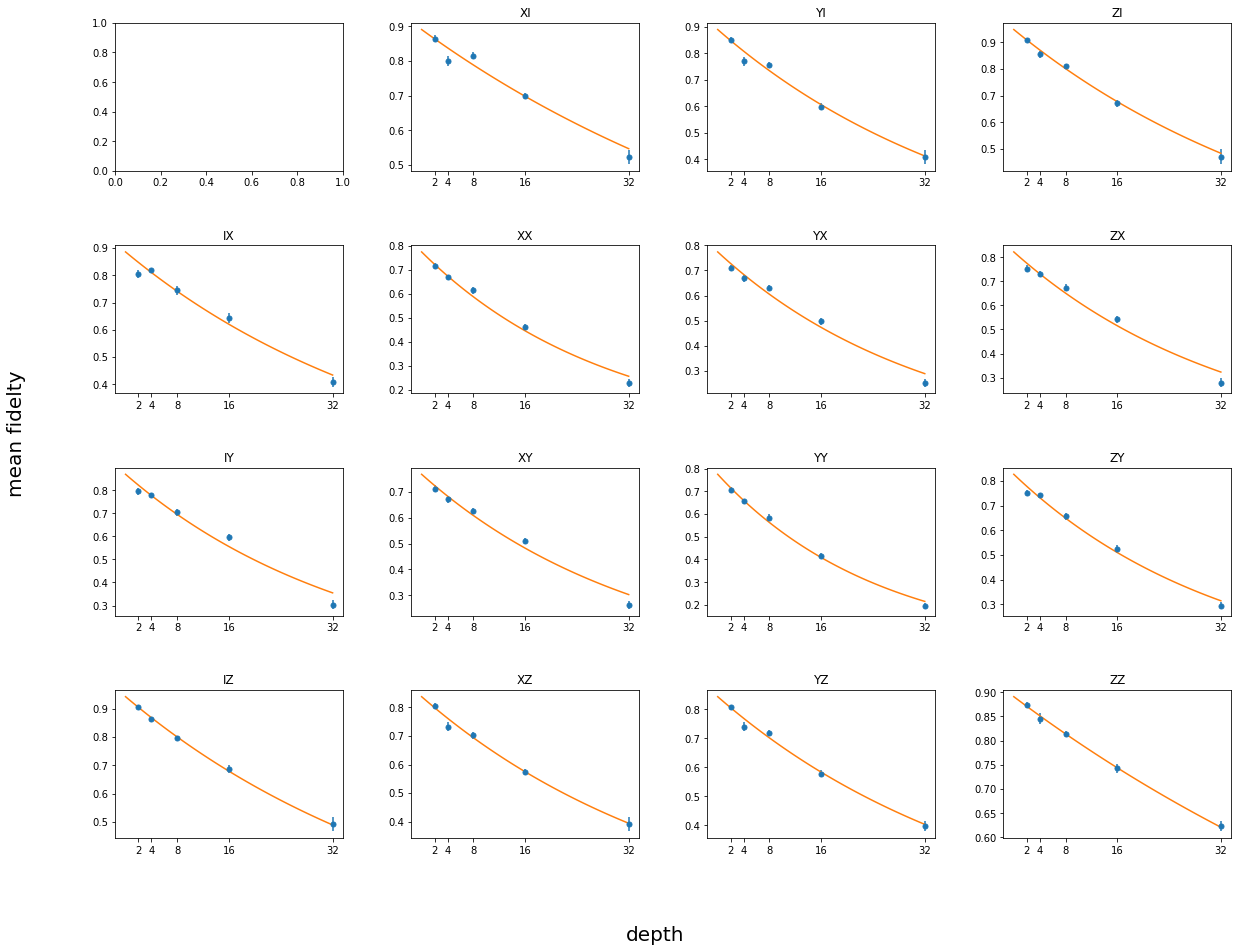

In [9]:
raw_fidelity_list = eab_result["fidelity_list"]
plot_dic={}
error_dic={}
# sys.exit(0)
# depth=[2,4,8,16,32]
fidelity_list = {}
stdev_list = {}
a_full_dic={}
Y_full_dic={}
Yerr_full_dic={}
for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        fidelity_list[pauli_label] = 1.0
        stdev_list[pauli_label] = 0.0
    else:
        alpha,a, alpha_err,Y, Yerr = fit_EAB_plot(depth, raw_fidelity_list[pauli_label])
        fidelity_list[pauli_label] = alpha #pauli fidelity from fit
        stdev_list[pauli_label] = alpha_err #error on pauli fidelity from fit
        a_full_dic[pauli_label]=a 
        Y_full_dic[pauli_label]=Y
        Yerr_full_dic[pauli_label]=Yerr

print("Parameters: n = %d, C = %d, " % (nqubit,C), "L = ", str(depth))
use_density_matrix=False
use_readout_error =False
# shots=2000
if use_density_matrix:
    print("Density matrix based simulation")
else:
    print("Measurement based simulation, shots = %d" % shots)

if use_readout_error is True:
    print("Measurement bitflip rate = %f" % eps_readout)
else:
    print("No readout error")

# Average fidelity
print("Total error = ", 1-np.mean(list(fidelity_list.values())))

print("Label / Pauli infidelity / Standard deviation")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], round(1-fidelity_list[pauli_label],7), round(stdev_list[pauli_label],7))
    plot_dic[pauli_label[::-1]]=1-fidelity_list[pauli_label]
    error_dic[pauli_label[::-1]]=stdev_list[pauli_label]


plot_full={}
plot_full=deepcopy(plot_dic)
err_full=deepcopy(error_dic)
# print (Y_full_dic)

x_c=np.linspace(0,32,num=80)
fig, axs = plt.subplots(4, 4)
fig.set_figwidth(20)
fig.set_figheight(15)
fig.subplots_adjust(hspace=0.5,wspace=0.3) 
fig.text(0.5, 0.03, 'depth', ha='center',fontsize=20)
fig.text(0.05, 0.5, 'mean fidelty', va='center', rotation='vertical',fontsize=20)
for i in range (4):
    for j in range(4):
        pauli_label=pauli_request_list[4*i+j]
        if (pauli_label == 'I'*nqubit):
            pass
        else:
            axs[i, j].set_xticks(depth)   
            axs[i, j].errorbar(depth,Y_full_dic[pauli_label], yerr=Yerr_full_dic[pauli_label], fmt='o',markersize=5)
            axs[i, j].plot(x_c,rcs_fit_fun(x_c,a_full_dic[pauli_label], fidelity_list[pauli_label]))
            axs[i, j].set_title(pauli_label[::-1])
                
# for pauli_label in pauli_request_list:
# fig.savefig("fit.pdf", format="pdf", dpi=500)        

In [10]:
error_list = fidelity_to_error(fidelity_list,nqubit)
print("Label / Pauli error rates")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], round(error_list[pauli_label],7))


Label / Pauli error rates
II 0.9764013
XI 0.0022293
YI 0.0003459
ZI 0.0035358
IX 0.0017687
XX 0.0018107
YX 0.0024843
ZX 0.0003965
IY 0.0004906
XY 0.0030419
YY 0.0001283
ZY 4.25e-05
IZ 0.0064395
XZ 0.0002393
YZ 9.26e-05
ZZ 0.0005529


scatter plot: result from each circuit

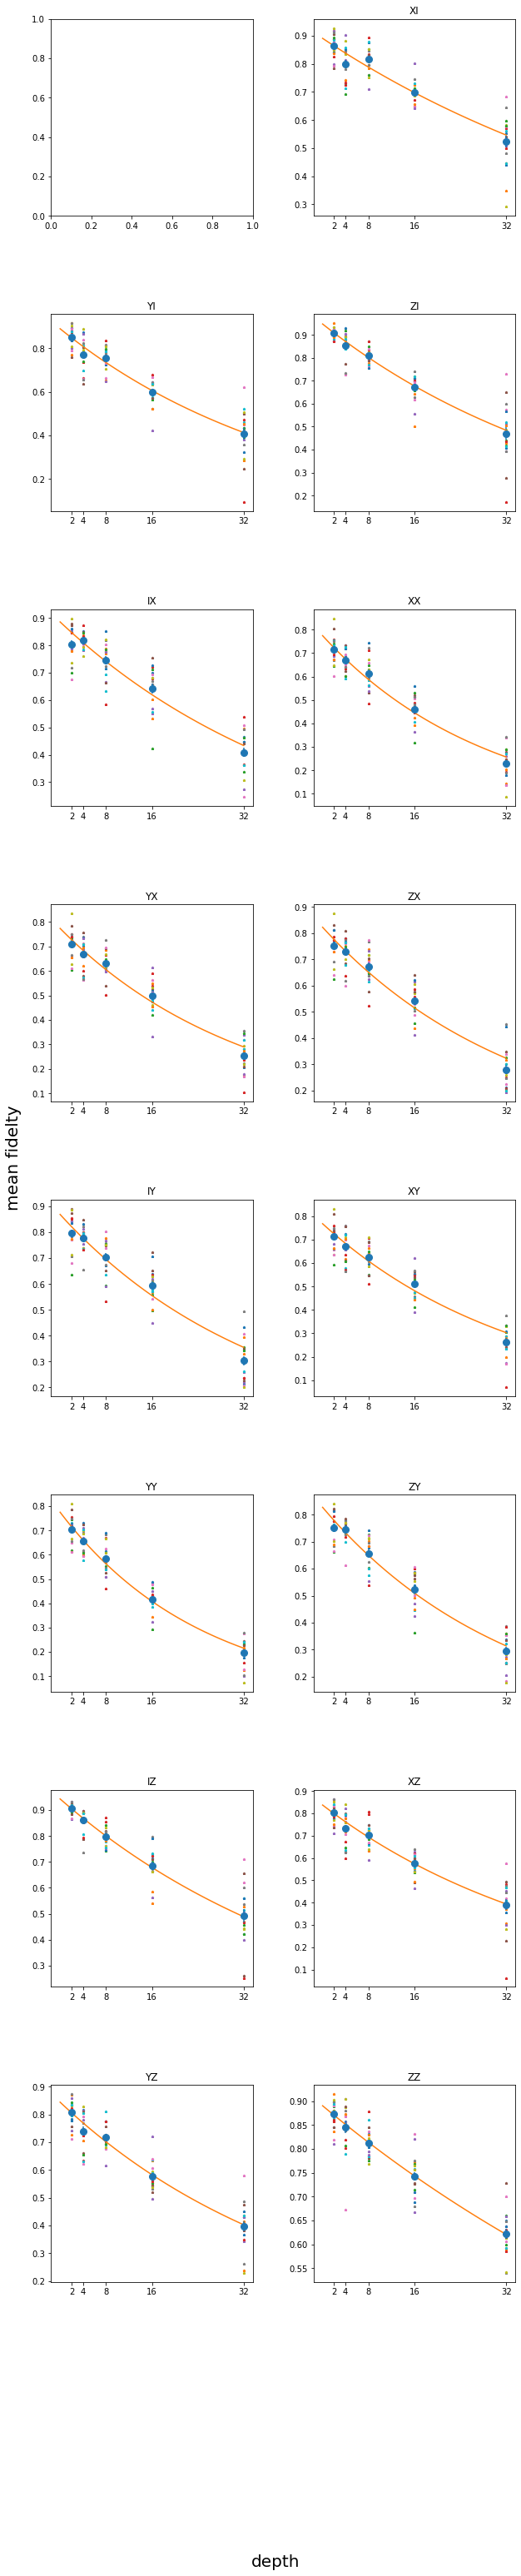

In [11]:
x_c=np.linspace(0,32,num=80)
# nqubit=2
fig, axs = plt.subplots(8, 2)
fig.set_figwidth(10)
fig.set_figheight(50)
fig.subplots_adjust(hspace=0.5,wspace=0.3) 
fig.text(0.5, 0.03, 'depth', ha='center',fontsize=20)
fig.text(0.05, 0.5, 'mean fidelty', va='center', rotation='vertical',fontsize=20)
for i in range (8):
    for j in range(2):
        pauli_label=pauli_request_list[2*i+j]
        if (pauli_label == 'I'*nqubit):
#                 fidelity_list[pauli_label] = 1.0
#                 stdev_list[pauli_label] = 0.0
            pass
        else:
            axs[i, j].set_xticks(depth)   
#             print ([tuple(eab_result['fidelity_list'][pauli_label][2])])
            axs[i, j].plot(depth,[tuple(eab_result['fidelity_list'][pauli_label][L]) for L in depth],"*",markersize=3)
            axs[i, j].errorbar(depth,Y_full_dic[pauli_label], yerr=Yerr_full_dic[pauli_label], fmt='o',markersize=8)
            axs[i, j].plot(x_c,rcs_fit_fun(x_c,a_full_dic[pauli_label], fidelity_list[pauli_label]))
            axs[i, j].set_title(pauli_label[::-1])
                
# for pauli_label in pauli_request_list:
# fig.savefig("fit.pdf", format="pdf", dpi=500)        

# data analysis with bootstrapping

full set of data with bootstrapping

In [12]:
import bootstrap

raw_fidelity_list = eab_result["fidelity_list"]
plot_dic={}
error_dic={}
# sys.exit(0)
# depth=[2,4,8,16,32]
fidelity_list = {}
stdev_list = {}
alpha_detail={}
a_detail={}
alpha_error_detail={}
Y_detail={}
Y_err_detail={}
a_BS_dic={}
Y_BS_dic={}
Yerr_BS_dic={}
for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        fidelity_list[pauli_label] = 1.0
        stdev_list[pauli_label] = 0.0
    else:
        alpha_bootstrap,alpha_err_bootstrap, alpha_rtn_frm_fit,a_rtn_frm_fit, alpha_err_rtn_frm_fit,Y_rtn_frm_fit,Yerr_rtn_frm_fit = bootstrap.bootstrap_fit_EAB_plot_rs(depth, raw_fidelity_list[pauli_label],15)
        fidelity_list[pauli_label] = alpha_bootstrap #avg pauli fidelity from fit
        stdev_list[pauli_label] = alpha_err_bootstrap #error on pauli fidelity from fit
        a_BS_dic[pauli_label]=a_rtn_frm_fit
        Y_BS_dic[pauli_label]=Y_rtn_frm_fit
        Yerr_BS_dic[pauli_label]=Yerr_rtn_frm_fit 
        alpha_detail[pauli_label]=alpha_rtn_frm_fit
        alpha_error_detail[pauli_label]=alpha_err_rtn_frm_fit


# pauli_label="IX"
# print (Y_BS_dic["IX"][0])    
# print (Yerr_BS_dic["IX"][0])  
# print (a_BS_dic["IX"][0])
# print (alpha_detail[pauli_label][0])


Method I: use the average of the 10 sets of Pauli fidelities from 10 times of resampling in bootstrapping


XI 0.0150659 0.0005734
YI 0.0237424 0.0004144
ZI 0.0209541 0.0005688
IX 0.0224462 0.0006413
XX 0.0339608 0.0010272
YX 0.0299039 0.0008441
ZX 0.0282537 0.0006386
IY 0.0268676 0.0011383
XY 0.0288556 0.0006759
YY 0.0391949 0.0011367
ZY 0.0298357 0.0005632
IZ 0.0202787 0.0005649
XZ 0.0232035 0.0007381
YZ 0.0231329 0.0008043
ZZ 0.0114091 0.0003658
{'IX': [0.9842471289109779, 0.9840027685499256, 0.9845694678299268, 0.9852887630305315, 0.98437960290409, 0.9858620189240406, 0.985067600725804, 0.9851472014688557, 0.9855393044033477, 0.9852371228886251], 'IY': [0.9763521104834304, 0.9760307170283725, 0.9761251384035753, 0.9763468239868215, 0.9761015378955283, 0.9770226909760065, 0.976440826210881, 0.976538726694059, 0.9763116755658398, 0.9753056965807368], 'IZ': [0.9784879039367809, 0.9788178255291714, 0.9784599495411278, 0.9803749124764431, 0.9790826812206562, 0.9786005034282875, 0.9786098456722594, 0.9796120041031361, 0.9792198517945842, 0.9791930460366165], 'XI': [0.9777448545723616, 0.977080

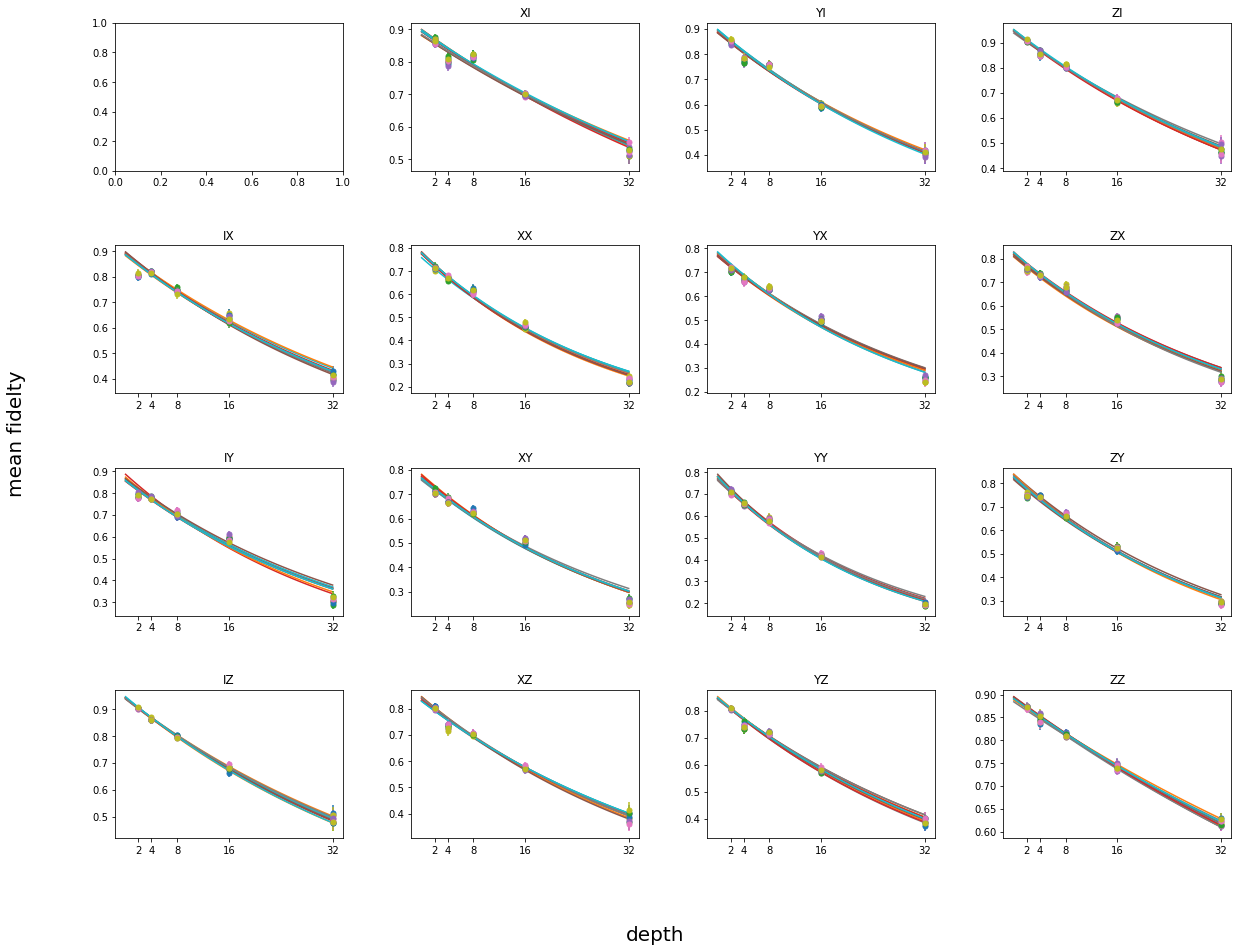

In [13]:
for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        continue
    else:
        print (pauli_label[::-1],round(1-fidelity_list[pauli_label],7),round(stdev_list[pauli_label],7))


x_c=np.linspace(0,32,num=80)
# nqubit=2
fig, axs = plt.subplots(4, 4)
fig.set_figwidth(20)
fig.set_figheight(15)
fig.subplots_adjust(hspace=0.5,wspace=0.3) 
fig.text(0.5, 0.03, 'depth', ha='center',fontsize=20)
fig.text(0.05, 0.5, 'mean fidelty', va='center', rotation='vertical',fontsize=20)
for i in range (4):
    for j in range(4):
        pauli_label=pauli_request_list[4*i+j]
        if (pauli_label == 'I'*nqubit):
#                 fidelity_list[pauli_label] = 1.0
#                 stdev_list[pauli_label] = 0.0
            pass
        else:
            axs[i, j].set_xticks(depth)   
            for m in range (10):
                axs[i, j].errorbar(depth,Y_BS_dic[pauli_label][m], yerr=Yerr_BS_dic[pauli_label][m], fmt='o',markersize=5)
                axs[i, j].plot(x_c,rcs_fit_fun(x_c,a_BS_dic[pauli_label][m], alpha_detail[pauli_label][m]))
            axs[i, j].set_title(pauli_label[::-1])

print (alpha_detail)    

Method II: use the average of the 10 sets of Y from resampling as the a new set of Y and do the fit once with the new Y


Parameters: n = 2, C = 20,  L =  [2, 4, 8, 16, 32]
Measurement based simulation, shots = 2000
No readout error
Total error =  0.023657954195991926
Label / Pauli infidelity / Standard deviation
II 0.0 0.0
XI 0.0152336 0.0001727
YI 0.0240271 0.0001799
ZI 0.0212076 0.0001937
IX 0.0202689 0.000241
XX 0.0334148 0.0003162
YX 0.0292201 0.0002932
ZX 0.0306844 0.0002529
IY 0.0267766 0.0002893
XY 0.0294395 0.0002915
YY 0.0401829 0.0002593
ZY 0.0299451 0.0001909
IZ 0.02038 0.0001696
XZ 0.0231863 0.0002256
YZ 0.0230683 0.0001892
ZZ 0.011492 9.65e-05
{'IX': [0.8639533333333335, 0.80266, 0.8166133333333334, 0.6978199999999999, 0.5259933333333333], 'IY': [0.8501466666666667, 0.7779933333333333, 0.7579866666666667, 0.5959200000000001, 0.40852666666666676], 'IZ': [0.90772, 0.8557266666666667, 0.8058399999999999, 0.6692533333333333, 0.47212000000000004], 'XI': [0.80576, 0.8192533333333332, 0.7455266666666666, 0.6386533333333333, 0.40756666666666674], 'XX': [0.7132866666666666, 0.6701133333333333, 0.6146

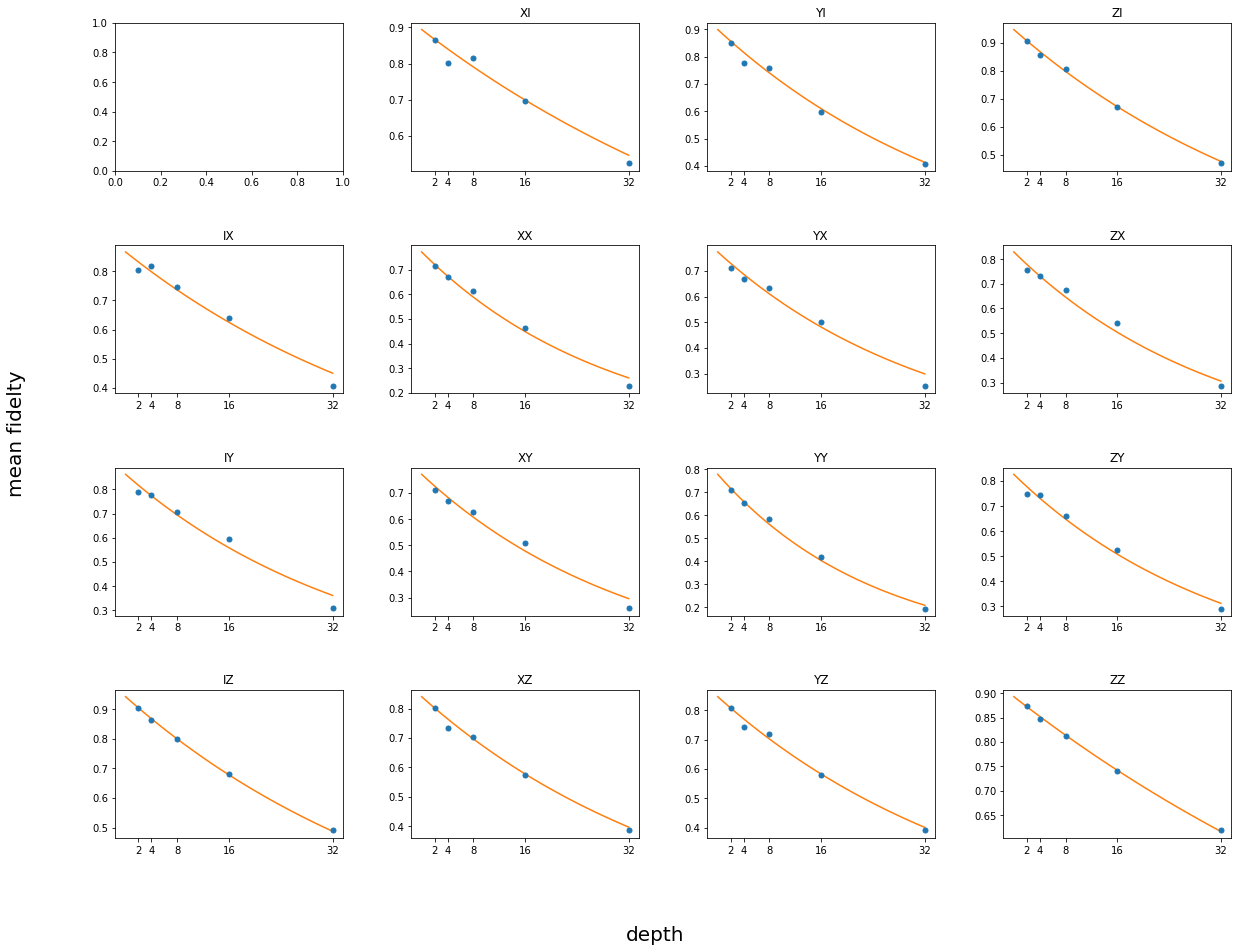

In [14]:
raw_fidelity_list_avg={}
for pauli_label in pauli_request_list:
    raw_fidelity_list_avg[pauli_label]={}
    raw_fidelity_list_avg[pauli_label][2]=[]
    raw_fidelity_list_avg[pauli_label][4]=[]
    raw_fidelity_list_avg[pauli_label][8]=[]
    raw_fidelity_list_avg[pauli_label][16]=[]
    raw_fidelity_list_avg[pauli_label][32]=[]
    if (pauli_label=="II"):
        raw_fidelity_list_avg[pauli_label][2]=[1.0]*10
        raw_fidelity_list_avg[pauli_label][4]=[1.0]*10
        raw_fidelity_list_avg[pauli_label][8]=[1.0]*10
        raw_fidelity_list_avg[pauli_label][16]=[1.0]*10
        raw_fidelity_list_avg[pauli_label][32]=[1.0]*10
    else:
        for i in range (10):
            raw_fidelity_list_avg[pauli_label][2].append(Y_BS_dic[pauli_label][i][0])
            raw_fidelity_list_avg[pauli_label][4].append(Y_BS_dic[pauli_label][i][1])
            raw_fidelity_list_avg[pauli_label][8].append(Y_BS_dic[pauli_label][i][2])
            raw_fidelity_list_avg[pauli_label][16].append(Y_BS_dic[pauli_label][i][3])
            raw_fidelity_list_avg[pauli_label][32].append(Y_BS_dic[pauli_label][i][4])


raw_fidelity_list = raw_fidelity_list_avg
plot_dic={}
error_dic={}
# sys.exit(0)
depth=[2,4,8,16,32]
fidelity_list = {}
stdev_list = {}
a_full_dic={}
Y_full_dic={}
Yerr_full_dic={}
for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        fidelity_list[pauli_label] = 1.0
        stdev_list[pauli_label] = 0.0
    else:
        alpha,a, alpha_err,Y, Yerr = fit_EAB_plot(depth, raw_fidelity_list[pauli_label])
        fidelity_list[pauli_label] = alpha #pauli fidelity from fit
        stdev_list[pauli_label] = alpha_err #error on pauli fidelity from fit
        a_full_dic[pauli_label]=a 
        Y_full_dic[pauli_label]=Y
        Yerr_full_dic[pauli_label]=Yerr

print("Parameters: n = %d, C = %d, " % (nqubit,C), "L = ", str(depth))
use_density_matrix=False
use_readout_error =False
shots=2000
if use_density_matrix:
    print("Density matrix based simulation")
else:
    print("Measurement based simulation, shots = %d" % shots)

if use_readout_error is True:
    print("Measurement bitflip rate = %f" % eps_readout)
else:
    print("No readout error")

# Average fidelity
print("Total error = ", 1-np.mean(list(fidelity_list.values())))

print("Label / Pauli infidelity / Standard deviation")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], round(1-fidelity_list[pauli_label],7), round(stdev_list[pauli_label],7))
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))
    plot_dic[pauli_label[::-1]]=1-fidelity_list[pauli_label]
    error_dic[pauli_label[::-1]]=stdev_list[pauli_label]


plot_full={}
plot_full=deepcopy(plot_dic)
err_full=deepcopy(error_dic)
print (Y_full_dic)

x_c=np.linspace(0,32,num=80)
nqubit=2
fig, axs = plt.subplots(4, 4)
fig.set_figwidth(20)
fig.set_figheight(15)
fig.subplots_adjust(hspace=0.5,wspace=0.3) 
fig.text(0.5, 0.03, 'depth', ha='center',fontsize=20)
fig.text(0.05, 0.5, 'mean fidelty', va='center', rotation='vertical',fontsize=20)
for i in range (4):
    for j in range(4):
        pauli_label=pauli_request_list[4*i+j]
        if (pauli_label == 'I'*nqubit):
            pass
        else:
            axs[i, j].set_xticks(depth)   
            axs[i, j].errorbar(depth,Y_full_dic[pauli_label], yerr=Yerr_full_dic[pauli_label], fmt='o',markersize=5)
            axs[i, j].plot(x_c,rcs_fit_fun(x_c,a_full_dic[pauli_label], fidelity_list[pauli_label]))
            axs[i, j].set_title(pauli_label[::-1])
                
# for pauli_label in pauli_request_list:
# fig.savefig("fit.pdf", format="pdf", dpi=500)  

In [15]:
error_list = fidelity_to_error(fidelity_list,nqubit)
print("Label / Pauli error rates")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], round(error_list[pauli_label],7))


Label / Pauli error rates
II 0.976342
XI 0.0025705
YI 0.0006675
ZI 0.0035636
IX 0.0019009
XX 0.0019573
YX 0.0027106
ZX 0.0001532
IY 0.0003064
XY 0.0029186
YY -6.26e-05
ZY 0.0003056
IZ 0.0063336
XZ 5.39e-05
YZ -0.0002119
ZZ 0.0004908


# Bootstrapping for different number of layers
Obtain the lists of:  
    alpha_detail[pauli_label]=alpha_rtn_frm_fit
    alpha_error_detail[pauli_label]=alpha_err_rtn_frm_fit
for different number of layers

plot alpha_detail vs. number of layers

In [18]:
#####dpth=[2,8]
raw_fidelity_list = eab_result["fidelity_list"]
depth=[2,8]
fidelity_list = {}
stdev_list = {}
a_detail={}
Y_detail={}
Y_err_detail={}
a_BS_dic={}
Y_BS_dic={}
Yerr_BS_dic={}

alpha_detail_d28={}
alpha_error_detail_d28={}

for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        alpha_detail_d28[pauli_label] = [1.0]*10
        alpha_error_detail_d28[pauli_label] = [0.0]*10
    else:
        alpha_bootstrap,alpha_err_bootstrap, alpha_rtn_frm_fit,a_rtn_frm_fit, alpha_err_rtn_frm_fit,Y_rtn_frm_fit,Yerr_rtn_frm_fit = bootstrap.bootstrap_fit_EAB_plot_rs(depth, raw_fidelity_list[pauli_label],15)
        alpha_detail_d28[pauli_label]=alpha_rtn_frm_fit
        alpha_error_detail_d28[pauli_label]=alpha_err_rtn_frm_fit
# print (alpha_detail_d28)
filename="alpha_detail_d28"
with open("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/for plotting/FT_EAB_0116/"+filename, "wb") as fp:
    pickle.dump(alpha_detail_d28, fp)


    #####dpth=[8,32]
raw_fidelity_list = eab_result["fidelity_list"]
depth=[8,32]
fidelity_list = {}
stdev_list = {}
a_detail={}
Y_detail={}
Y_err_detail={}
a_BS_dic={}
Y_BS_dic={}
Yerr_BS_dic={}

alpha_detail_d832={}
alpha_error_detail_d832={}

for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        alpha_detail_d832[pauli_label] = [1.0]*10
        alpha_error_detail_d832[pauli_label] = [0.0]*10
    else:
        alpha_bootstrap,alpha_err_bootstrap, alpha_rtn_frm_fit,a_rtn_frm_fit, alpha_err_rtn_frm_fit,Y_rtn_frm_fit,Yerr_rtn_frm_fit = bootstrap.bootstrap_fit_EAB_plot_rs(depth, raw_fidelity_list[pauli_label],15)
        alpha_detail_d832[pauli_label]=alpha_rtn_frm_fit
        alpha_error_detail_d832[pauli_label]=alpha_err_rtn_frm_fit
# print (alpha_detail_d2)
filename="alpha_detail_d832"
with open("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/for plotting/FT_EAB_0116/"+filename, "wb") as fp:
    pickle.dump(alpha_detail_d832, fp)


####dpth=[2,4,8]
raw_fidelity_list = eab_result["fidelity_list"]
depth=[2,4,8]
fidelity_list = {}
stdev_list = {}
a_detail={}
Y_detail={}
Y_err_detail={}
a_BS_dic={}
Y_BS_dic={}
Yerr_BS_dic={}

alpha_detail_d248={}
alpha_error_detail_d248={}

for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        alpha_detail_d248[pauli_label] = [1.0]*10
        alpha_error_detail_d248[pauli_label] = [0.0]*10
    else:
        alpha_bootstrap,alpha_err_bootstrap, alpha_rtn_frm_fit,a_rtn_frm_fit, alpha_err_rtn_frm_fit,Y_rtn_frm_fit,Yerr_rtn_frm_fit = bootstrap.bootstrap_fit_EAB_plot_rs(depth, raw_fidelity_list[pauli_label],15)
        alpha_detail_d248[pauli_label]=alpha_rtn_frm_fit
        alpha_error_detail_d248[pauli_label]=alpha_err_rtn_frm_fit
# # print (alpha_detail_2)
filename="alpha_detail_d248"
with open("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/for plotting/FT_EAB_0116/"+filename, "wb") as fp:
    pickle.dump(alpha_detail_d248, fp)

#####dpth=[2,8,32]
raw_fidelity_list = eab_result["fidelity_list"]
depth=[2,8,32]
fidelity_list = {}
stdev_list = {}
a_detail={}
Y_detail={}
Y_err_detail={}
a_BS_dic={}
Y_BS_dic={}
Yerr_BS_dic={}

alpha_detail_d2832={}
alpha_error_detail_d2832={}

for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        alpha_detail_d2832[pauli_label] = [1.0]*10
        alpha_error_detail_d2832[pauli_label] = [0.0]*10
    else:
        alpha_bootstrap,alpha_err_bootstrap, alpha_rtn_frm_fit,a_rtn_frm_fit, alpha_err_rtn_frm_fit,Y_rtn_frm_fit,Yerr_rtn_frm_fit = bootstrap.bootstrap_fit_EAB_plot_rs(depth, raw_fidelity_list[pauli_label],15)
        alpha_detail_d2832[pauli_label]=alpha_rtn_frm_fit
        alpha_error_detail_d2832[pauli_label]=alpha_err_rtn_frm_fit
# print (alpha_detail_2)
filename="alpha_detail_d2832"
with open("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/for plotting/FT_EAB_0116/"+filename, "wb") as fp:
    pickle.dump(alpha_detail_d2832, fp)

####dpth=[2,4,8,16]
raw_fidelity_list = eab_result["fidelity_list"]
depth=[2,4,8,16]
fidelity_list = {}
stdev_list = {}
a_detail={}
Y_detail={}
Y_err_detail={}
a_BS_dic={}
Y_BS_dic={}
Yerr_BS_dic={}

alpha_detail_d24816={}
alpha_error_detail_d24816={}

for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        alpha_detail_d24816[pauli_label] = [1.0]*10
        alpha_error_detail_d24816[pauli_label] = [0.0]*10
    else:
        alpha_bootstrap,alpha_err_bootstrap, alpha_rtn_frm_fit,a_rtn_frm_fit, alpha_err_rtn_frm_fit,Y_rtn_frm_fit,Yerr_rtn_frm_fit = bootstrap.bootstrap_fit_EAB_plot_rs(depth, raw_fidelity_list[pauli_label],15)
        alpha_detail_d24816[pauli_label]=alpha_rtn_frm_fit
        alpha_error_detail_d24816[pauli_label]=alpha_err_rtn_frm_fit
# # print (alpha_detail_2)
filename="alpha_detail_d24816"
with open("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/for plotting/FT_EAB_0116/"+filename, "wb") as fp:
    pickle.dump(alpha_detail_d24816, fp)
    
####depth=[2,4,8,16,32]
alpha_detail_d2481632={}
alpha_error_detail_d2481632={}
alpha_detail_d2481632= alpha_detail
alpha_error_detail_d2481632=alpha_error_detail
alpha_detail_d2481632["II"] = [1.0]*10
alpha_error_detail_d2481632["II"] = [0.0]*10

filename="alpha_detail_d2481632"
with open("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/for plotting/FT_EAB_0116/"+filename, "wb") as fp:
    pickle.dump(alpha_detail_d2481632, fp)


In [9]:
# use 18 sample in bootstrapping instead of 15
import bootstrap
raw_fidelity_list = eab_result["fidelity_list"]
depth=[2,4,8,16,32]
fidelity_list = {}
stdev_list = {}
a_detail={}
Y_detail={}
Y_err_detail={}
a_BS_dic={}
Y_BS_dic={}
Yerr_BS_dic={}

alpha_detail_d2481632={}
alpha_error_detail_d2481632={}

for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        alpha_detail_d2481632[pauli_label] = [1.0]*10
        alpha_error_detail_d2481632[pauli_label] = [0.0]*10
    else:
        alpha_bootstrap,alpha_err_bootstrap, alpha_rtn_frm_fit,a_rtn_frm_fit, alpha_err_rtn_frm_fit,Y_rtn_frm_fit,Yerr_rtn_frm_fit = bootstrap.bootstrap_fit_EAB_plot_rs(depth, raw_fidelity_list[pauli_label],18)
        alpha_detail_d2481632[pauli_label]=alpha_rtn_frm_fit
        alpha_error_detail_d2481632[pauli_label]=alpha_err_rtn_frm_fit
# # print (alpha_detail_2)
filename="alpha_detail_d2481632"
with open("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/for plotting/bootstrap18samples/FTXX23_EAB_01+10_01162024/"+filename, "wb") as fp:
    pickle.dump(alpha_detail_d2481632, fp)

In [24]:
CB_alpha_detail_d28={}
CB_alpha_detail_d2832={}
CB_alpha_detail_d832={}
with open("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/CB_alpha_detail_d2", "rb") as fp:   # Unpickling
    CB_alpha_detail_d28 = pickle.load(fp)
with open("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/CB_alpha_detail_d3", "rb") as fp:   # Unpickling
    CB_alpha_detail_d2832 = pickle.load(fp)
with open("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/CB_alpha_detail_d4", "rb") as fp:   # Unpickling
    CB_alpha_detail_d832 = pickle.load(fp)

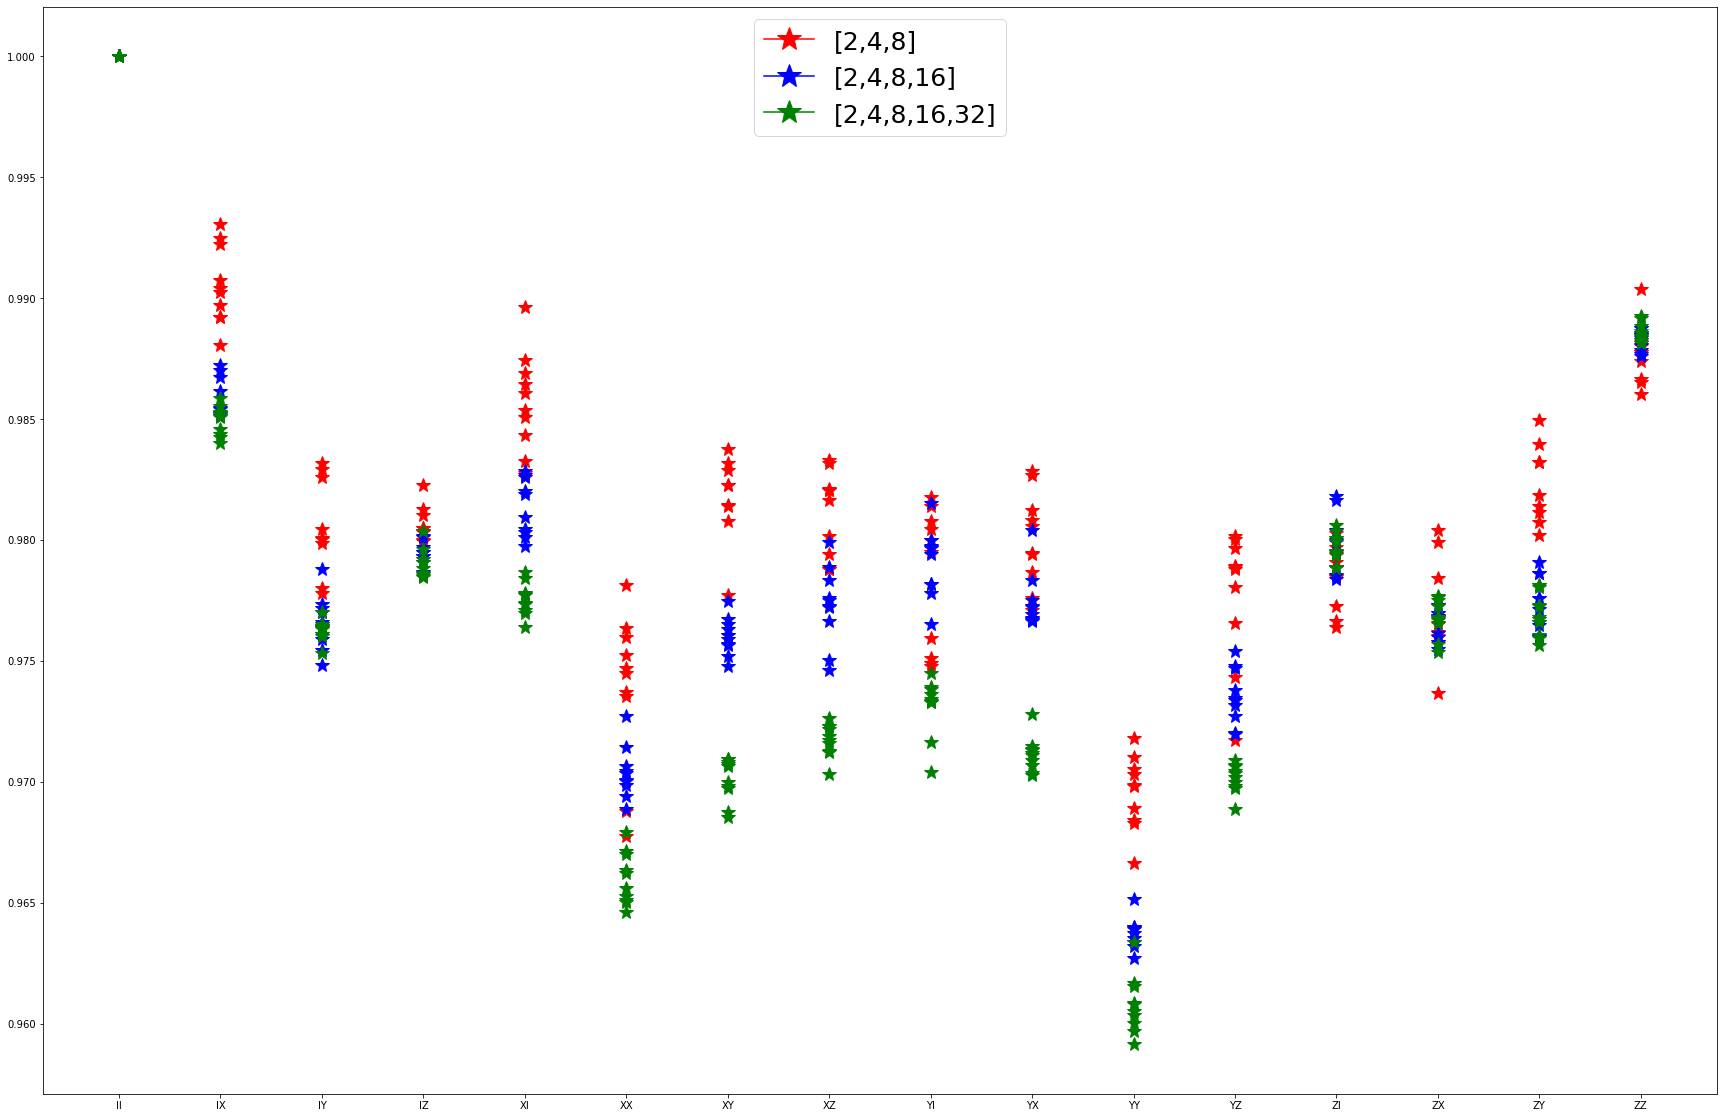

In [23]:
##plot  alpha_detail vs. depth
import seaborn as sns
pal = sns.color_palette("PRGn",20)
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
# fig, axs = plt.subplots(4, 4)
fig.set_figwidth(30)
fig.set_figheight(15)
fig.subplots_adjust(hspace=0.5,wspace=0.3) 
fig.text(0.5, 0.03, 'depth', ha='center',fontsize=20)
fig.text(0.05, 0.5, 'mean fidelty', va='center', rotation='vertical',fontsize=20)
# for i in range (4):
#     for j in range(4):
#         pauli_label=pauli_request_list[4*i+j]
#         if (pauli_label == 'I'*nqubit):
#             pass
#         else:
#             axs[i, j].set_xticks([2,4,8,16,32])   
#             axs[i, j].plot(depth,[tuple(eab_result['fidelity_list'][pauli_label][L]) for L in depth],"*",markersize=3)
# #             axs[i, j].errorbar(depth,Y_full_dic[pauli_label], yerr=Yerr_full_dic[pauli_label], fmt='o',markersize=5)
# #             axs[i, j].plot(x_c,rcs_fit_fun(x_c,a_full_dic[pauli_label], fidelity_list[pauli_label]))
#             axs[i, j].set_title(pauli_label[::-1])
plt.figure(figsize=(30,20))
plt.plot(pauli_request_list,[tuple(alpha_detail_d248[pauli_label]) for pauli_label in pauli_request_list],"r*",markersize=15,label='depth 2')
plt.plot(pauli_request_list,[tuple(alpha_detail_d24816[pauli_label]) for pauli_label in pauli_request_list],"b*",markersize=15,label='depth 3')
# plt.plot(pauli_request_list,[tuple(alpha_detail_d2_2[pauli_label]) for pauli_label in pauli_request_list],"g*",markersize=15,label='depth 4')

plt.plot(pauli_request_list,[tuple(alpha_detail_d2481632[pauli_label]) for pauli_label in pauli_request_list],"g*",markersize=15,label='depth 4')
# plt.plot(pauli_request_list,[tuple(alpha_detail_d5[pauli_label]) for pauli_label in pauli_request_list],"m*",markersize=15,label='depth 5')
legend_elements = [
# Line2D([0], [0], marker='*', color='r', label='[2,4]',markerfacecolor='r', markersize=25),
                   Line2D([0], [0], marker='*', color='r', label='[2,4,8]',markerfacecolor='r', markersize=25),
                   Line2D([0], [0], marker='*', color='b', label='[2,4,8,16]',markerfacecolor='b', markersize=25),
                   Line2D([0], [0], marker='*', color='g', label='[2,4,8,16,32]',markerfacecolor='g', markersize=25),
                  ]

# plt.plot(pauli_request_list,[tuple(CB_alpha_detail_d2[pauli_label]) for pauli_label in pauli_request_list],"r*",markersize=15,label='depth 2')
# plt.plot(pauli_request_list,[tuple(CB_alpha_detail_d3[pauli_label]) for pauli_label in pauli_request_list],"b*",markersize=15,label='depth 3')
# # plt.plot(pauli_request_list,[tuple(alpha_detail_d2_2[pauli_label]) for pauli_label in pauli_request_list],"g*",markersize=15,label='depth 4')

# plt.plot(pauli_request_list,[tuple(CB_alpha_detail_d4[pauli_label]) for pauli_label in pauli_request_list],"g*",markersize=15,label='depth 4')

plt.legend(handles=legend_elements, loc='upper center',fontsize=25)
# plt.legend()
# for pauli_label in pauli_request_list:
# fig.savefig("fit.pdf", format="pdf", dpi=500)  

# plt.figure(figsize=(30,20))
#  plt.plot(pauli_request_list,[tuple(alpha_detail_d2[pauli_label]) for pauli_label in pauli_request_list],"r*",markersize=15,label='depth 2')
# plt.plot(pauli_request_list,[tuple(alpha_detail_d3[pauli_label]) for pauli_label in pauli_request_list],"b*",markersize=15,label='depth 3')
# plt.plot(pauli_request_list,[tuple(alpha_detail_d4[pauli_label]) for pauli_label in pauli_request_list],"g*",markersize=15,label='depth 4')
# plt.plot(pauli_request_list,[tuple(alpha_detail_d5[pauli_label]) for pauli_label in pauli_request_list],"m*",markersize=15,label='depth 5')
# plt.legend()

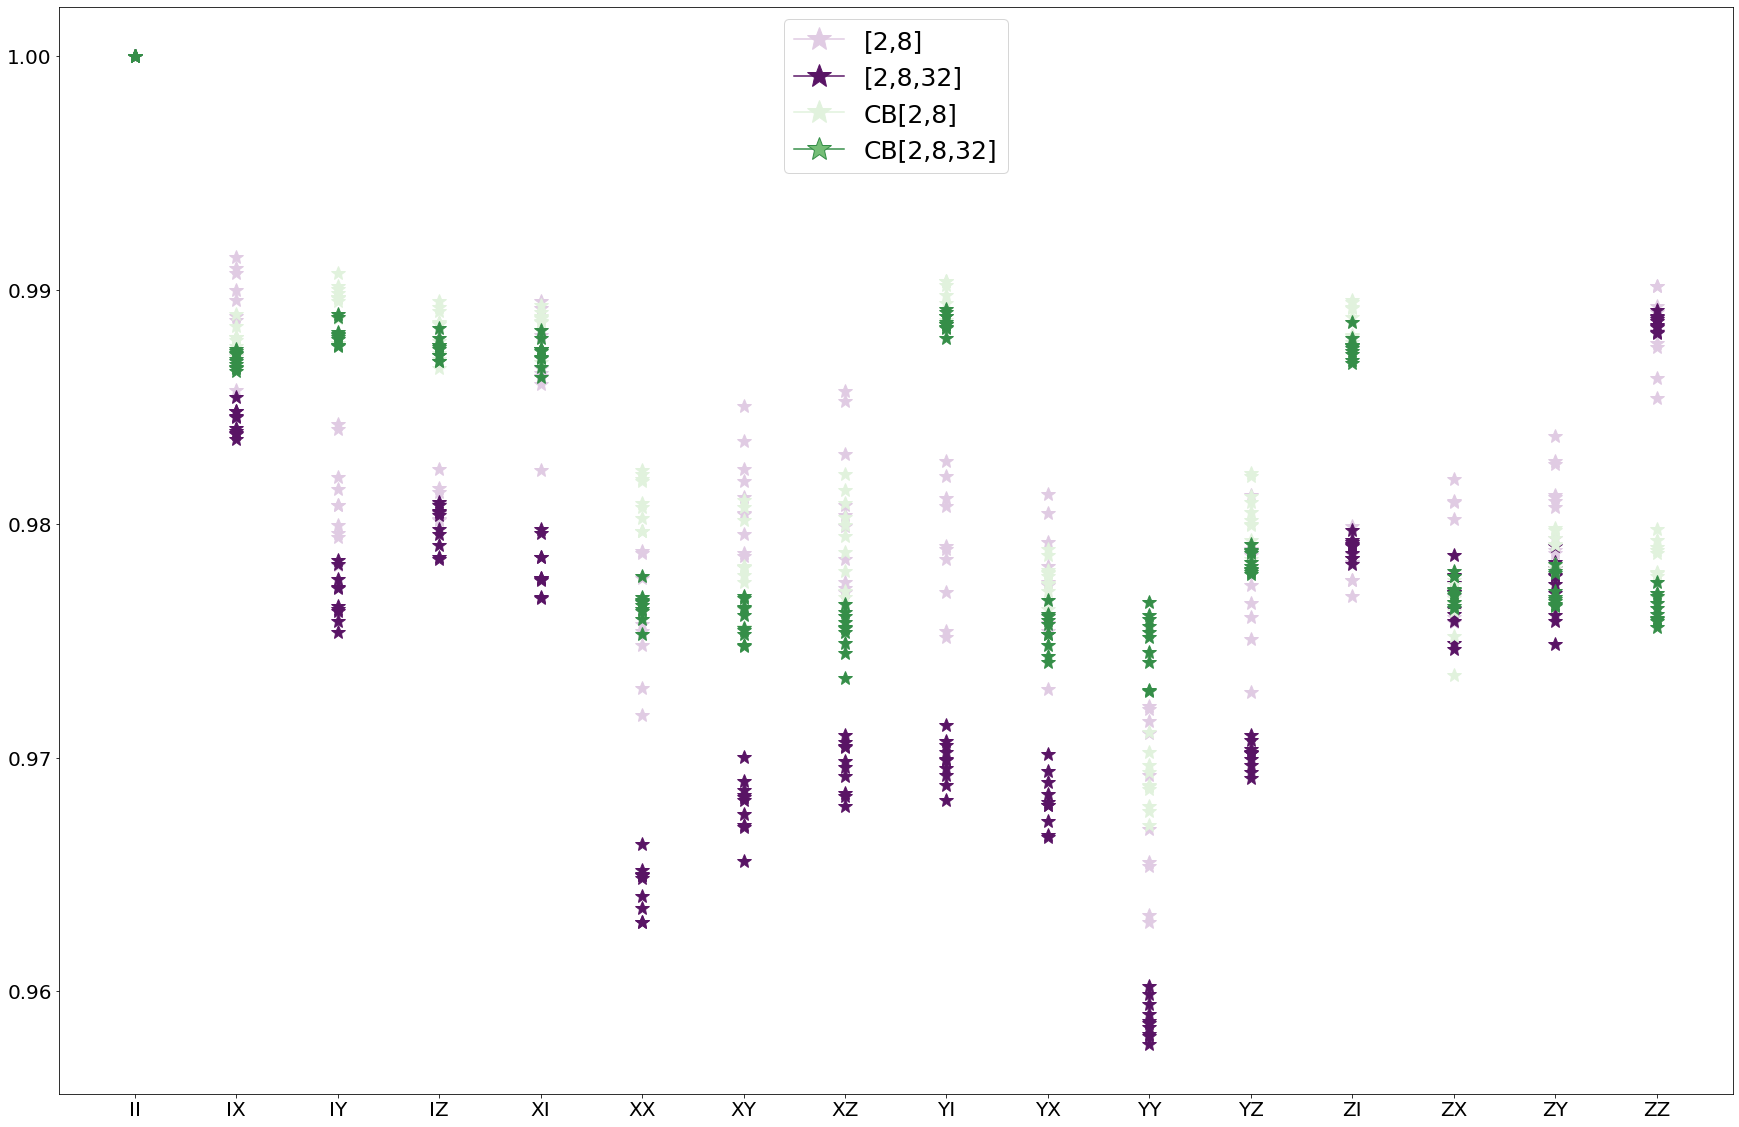

In [25]:
##plot  alpha_detail vs. depth
import seaborn as sns
pal = sns.color_palette("PRGn",20)
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
# fig, axs = plt.subplots(4, 4)
fig.set_figwidth(30)
fig.set_figheight(15)
fig.subplots_adjust(hspace=0.5,wspace=0.3) 
fig.text(0.5, 0.03, 'depth', ha='center',fontsize=30)
fig.text(0.05, 0.5, 'mean fidelty', va='center', rotation='vertical',fontsize=20)
plt.rcParams.update({'font.size': 20})
# for i in range (4):
#     for j in range(4):
#         pauli_label=pauli_request_list[4*i+j]
#         if (pauli_label == 'I'*nqubit):
#             pass
#         else:
#             axs[i, j].set_xticks([2,4,8,16,32])   
#             axs[i, j].plot(depth,[tuple(eab_result['fidelity_list'][pauli_label][L]) for L in depth],"*",markersize=3)
# #             axs[i, j].errorbar(depth,Y_full_dic[pauli_label], yerr=Yerr_full_dic[pauli_label], fmt='o',markersize=5)
# #             axs[i, j].plot(x_c,rcs_fit_fun(x_c,a_full_dic[pauli_label], fidelity_list[pauli_label]))
#             axs[i, j].set_title(pauli_label[::-1])
plt.figure(figsize=(30,20))
plt.plot(pauli_request_list,[tuple(alpha_detail_d28[pauli_label]) for pauli_label in pauli_request_list],color=pal[7],marker="*",linestyle='None',markersize=15,label='depth 2')
plt.plot(pauli_request_list,[tuple(alpha_detail_d2832[pauli_label]) for pauli_label in pauli_request_list],color=pal[0],marker="*",linestyle='None',markersize=15,label='depth 3')
# plt.plot(pauli_request_list,[tuple(alpha_detail_d2_2[pauli_label]) for pauli_label in pauli_request_list],"g*",markersize=15,label='depth 4')

# plt.plot(pauli_request_list,[tuple(alpha_detail_d4[pauli_label]) for pauli_label in pauli_request_list],color=pal[3],marker="*",linestyle='None',markersize=15,label='depth 4')
# plt.plot(pauli_request_list,[tuple(alpha_detail_d5[pauli_label]) for pauli_label in pauli_request_list],color=pal[0],marker="*",linestyle='None',markersize=15,label='depth 5')
plt.plot(pauli_request_list,[tuple(CB_alpha_detail_d28[pauli_label]) for pauli_label in pauli_request_list],color=pal[11],marker="*",linestyle='None',markersize=15,label='depth 2')
plt.plot(pauli_request_list,[tuple(CB_alpha_detail_d2832[pauli_label]) for pauli_label in pauli_request_list],color=pal[17],marker="*",linestyle='None',markersize=15,label='depth 3')
# plt.plot(pauli_request_list,[tuple(alpha_detail_d2_2[pauli_label]) for pauli_label in pauli_request_list],"g*",markersize=15,label='depth 4')

# plt.plot(pauli_request_list,[tuple(CB_alpha_detail_d832[pauli_label]) for pauli_label in pauli_request_list],color=pal[18],marker="*",linestyle='None',markersize=15,label='depth 4')

legend_elements = [Line2D([0], [0], marker='*', color=pal[7], label='[2,8]',markerfacecolor=pal[7], markersize=25),
#                    Line2D([0], [0], marker='*', color=pal[5], label='[2,4,8]',markerfacecolor=pal[5], markersize=25),
#                    Line2D([0], [0], marker='*', color=pal[3], label='[2,4,8,16]',markerfacecolor=pal[3], markersize=25),
                   Line2D([0], [0], marker='*', color=pal[0], label='[2,8,32]',markerfacecolor=pal[0], markersize=25),
                   Line2D([0], [0], marker='*', color=pal[11], label='CB[2,8]',markerfacecolor=pal[11], markersize=25),
                   Line2D([0], [0], marker='*', color=pal[17], label='CB[2,8,32]',markerfacecolor=pal[15], markersize=25),
#                    Line2D([0], [0], marker='*', color=pal[17], label='CB[8,32]',markerfacecolor=pal[17], markersize=25),
                  
                  ]


plt.legend(handles=legend_elements, loc='upper center',fontsize=25)
# plt.leg

In [ ]:
##plot  alpha_detail vs. depth
import seaborn as sns
pal = sns.color_palette("PRGn",20)
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
# fig, axs = plt.subplots(4, 4)
fig.set_figwidth(30)
fig.set_figheight(15)
fig.subplots_adjust(hspace=0.5,wspace=0.3) 
fig.text(0.5, 0.03, 'depth', ha='center',fontsize=30)
fig.text(0.05, 0.5, 'mean fidelty', va='center', rotation='vertical',fontsize=20)
plt.rcParams.update({'font.size': 20})
# for i in range (4):
#     for j in range(4):
#         pauli_label=pauli_request_list[4*i+j]
#         if (pauli_label == 'I'*nqubit):
#             pass
#         else:
#             axs[i, j].set_xticks([2,4,8,16,32])   
#             axs[i, j].plot(depth,[tuple(eab_result['fidelity_list'][pauli_label][L]) for L in depth],"*",markersize=3)
# #             axs[i, j].errorbar(depth,Y_full_dic[pauli_label], yerr=Yerr_full_dic[pauli_label], fmt='o',markersize=5)
# #             axs[i, j].plot(x_c,rcs_fit_fun(x_c,a_full_dic[pauli_label], fidelity_list[pauli_label]))
#             axs[i, j].set_title(pauli_label[::-1])
plt.figure(figsize=(30,20))
plt.plot(pauli_request_list,[tuple(alpha_detail_d2[pauli_label]) for pauli_label in pauli_request_list],color=pal[7],marker="*",linestyle='None',markersize=15,label='depth 2')
plt.plot(pauli_request_list,[tuple(alpha_detail_d2_2[pauli_label]) for pauli_label in pauli_request_list],color=pal[5],marker="*",linestyle='None',markersize=15,label='depth 3')
# plt.plot(pauli_request_list,[tuple(alpha_detail_d2_2[pauli_label]) for pauli_label in pauli_request_list],"g*",markersize=15,label='depth 4')

plt.plot(pauli_request_list,[tuple(alpha_detail_d3[pauli_label]) for pauli_label in pauli_request_list],color=pal[3],marker="*",linestyle='None',markersize=15,label='depth 4')
# plt.plot(pauli_request_list,[tuple(alpha_detail_d5[pauli_label]) for pauli_label in pauli_request_list],color=pal[0],marker="*",linestyle='None',markersize=15,label='depth 5')
plt.plot(pauli_request_list,[tuple(CB_alpha_detail_d28[pauli_label]) for pauli_label in pauli_request_list],color=pal[11],marker="*",linestyle='None',markersize=15,label='depth 2')
plt.plot(pauli_request_list,[tuple(CB_alpha_detail_d2832[pauli_label]) for pauli_label in pauli_request_list],color=pal[15],marker="*",linestyle='None',markersize=15,label='depth 3')
# plt.plot(pauli_request_list,[tuple(alpha_detail_d2_2[pauli_label]) for pauli_label in pauli_request_list],"g*",markersize=15,label='depth 4')

plt.plot(pauli_request_list,[tuple(CB_alpha_detail_d832[pauli_label]) for pauli_label in pauli_request_list],color=pal[18],marker="*",linestyle='None',markersize=15,label='depth 4')

legend_elements = [Line2D([0], [0], marker='*', color=pal[7], label='[2,8]',markerfacecolor=pal[7], markersize=25),
                   Line2D([0], [0], marker='*', color=pal[5], label='[2,4,8]',markerfacecolor=pal[5], markersize=25),
                   Line2D([0], [0], marker='*', color=pal[3], label='[2,4,8,16]',markerfacecolor=pal[3], markersize=25),
                   Line2D([0], [0], marker='*', color=pal[0], label='[2,4,8,16,32]',markerfacecolor=pal[0], markersize=25),
                   Line2D([0], [0], marker='*', color=pal[11], label='CB[2,8]',markerfacecolor=pal[11], markersize=25),
                   Line2D([0], [0], marker='*', color=pal[15], label='CB[2,8,32]',markerfacecolor=pal[15], markersize=25),
                   Line2D([0], [0], marker='*', color=pal[17], label='CB[8,32]',markerfacecolor=pal[17], markersize=25),
                  
                  ]


plt.legend(handles=legend_elements, loc='upper center',fontsize=25)
# plt.leg